In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1_101-all-classes.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "TEST"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 101
BATCH_SIZE = 256
EPOCHS = 5
learning_rate = 0.0005
NUM_WORKERS = 0
IMP_WEIGHT = 1

In [6]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [8]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')

In [9]:
for entry in header:
  print(entry)




Last Run: 2021-09-20 19:42:52.317296+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: False
Using CUDA device: cpu
Random Seed: 42
NUM WORKERS: 0
Model Name: TEST
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/TEST
-------------------HyperParameters---------------
No. of Classes: 101
Batch size: 256
Grayscale: False
Learning Rate: 0.0005
Epochs: 5


In [10]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

In [11]:
df = pd.read_csv(TRAIN_CSV_PATH)
labels = df['label'].values
del df
labels = torch.tensor(labels, dtype=torch.float)
print(labels.size())

torch.Size([23689])


In [12]:
# uniq = torch.unique(labels) #1-101, !94,97,98
# # print(uniq)
# num_examples = labels.size(0) #23689
# # print(num_examples)

# """# m = torch.zeros(uniq.shape[0]) #tensor of 98 zeros"""
# m = torch.zeros(int(torch.max(labels).item())) #tensor of 101 zeros
# print(m.shape)

# j=27
# lol = torch.arange(torch.min(uniq), torch.max(uniq))
# # print(lol) #1-100
# x = torch.tensor(labels[labels > j]).size(0)
# print(x) #no. of examples that have ages greater than j
# y = num_examples - labels[labels > j].size(0)
# # print(y) #no. of examples have ages less than or equal to j
# a = torch.tensor([x, y]) #a tensor with two elements
# # print(a)
# max = torch.max(a)
# # print(max) #so samples greater than age 1 are more
# root = torch.sqrt(max.float())
# # print(root) # square root of max of a

# for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq)+1)):
#   print(i,t)
#   m_k = torch.max(torch.tensor([labels[labels > t].size(0),
#                                 num_examples - labels[labels > t].size(0)]))
#   print(m_k)
#   m[i] = torch.sqrt(m_k.float())

# imp = m/torch.max(m)
# print(m)
# print(imp)

In [13]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    # m = torch.zeros(uniq.shape[0])
    m = torch.zeros(int(torch.max(labels).item())) #tensor of 101 zeros

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq)+1)):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())
        print(i+1, '\t', m[i])
    imp = m/torch.max(m)
    print(imp)
    return m, imp

In [14]:
# Data-specific scheme
if not IMP_WEIGHT:
    # imp = torch.ones(NUM_CLASSES-1, dtype=torch.float)
    imp = torch.ones(NUM_CLASSES, dtype=torch.float)
elif IMP_WEIGHT == 1:
    m, imp = task_importance_weights(labels)
    # imp = imp[0:NUM_CLASSES-1]
    imp = imp[0:NUM_CLASSES]
    # print(imp.shape)
else:
    raise ValueError('Incorrect importance weight parameter.')
imp = imp.to(DEVICE)

1 	 tensor(150.2198)
2 	 tensor(148.6069)
3 	 tensor(147.6313)
4 	 tensor(146.7038)
5 	 tensor(146.0342)
6 	 tensor(145.5850)
7 	 tensor(145.1069)
8 	 tensor(144.1978)
9 	 tensor(143.6210)
10 	 tensor(143.0769)
11 	 tensor(142.8496)
12 	 tensor(142.3938)
13 	 tensor(142.1091)
14 	 tensor(141.5556)
15 	 tensor(140.9291)
16 	 tensor(140.0500)
17 	 tensor(139.4848)
18 	 tensor(138.5424)
19 	 tensor(138.1883)
20 	 tensor(137.1568)
21 	 tensor(135.8897)
22 	 tensor(134.4284)
23 	 tensor(132.8345)
24 	 tensor(129.5608)
25 	 tensor(126.6965)
26 	 tensor(117.7073)
27 	 tensor(115.0652)
28 	 tensor(111.0045)
29 	 tensor(109.2566)
30 	 tensor(112.5211)
31 	 tensor(114.0658)
32 	 tensor(116.9402)
33 	 tensor(117.5500)
34 	 tensor(119.2770)
35 	 tensor(122.9105)
36 	 tensor(124.8599)
37 	 tensor(126.0278)
38 	 tensor(127.3106)
39 	 tensor(128.3511)
40 	 tensor(130.3840)
41 	 tensor(130.8893)
42 	 tensor(131.9015)
43 	 tensor(132.4953)
44 	 tensor(132.8721)
45 	 tensor(134.5177)
46 	 tensor(135.085

 **Dataset**

In [15]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir,start, end, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[start:end]
          # df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        # levels = [1]*label + [0]*(NUM_CLASSES - 1 - label) #converting labels to levels..so if age is 22, 22 ones and (96-22) zeros
        levels = [1]*label + [0]*(NUM_CLASSES - label) #converting labels to levels..so if age is 22, 22 ones and (79-22) zeros, since total class is 101
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [16]:
custom_transform_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = 1, # None
                               start = 11435,
                            end = 11436,
                               )

# image, label, level = train_dataset.__getitem__()
# label, level, level.shape

**Dataset Entity Distribution Analysis**

In [17]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount\t\tw\t\tscaled")
  for (label, key, value, i) in zip(counter_label.keys(), counter_age.keys(), counter_age.values(), m):
    print(label,'\t\t',key,'\t\t', value,'\t    ',format(i.item(), ".3f"), '\t\t',format(i/torch.max(m), ".3f"))

  print(torch.from_numpy(d.age).bincount())
  # imp = m/torch.max(m)
  # print(imp)
  print('length of the dataset is: ', len(d))

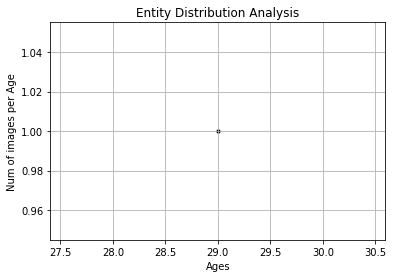

label		Age		Count		w		scaled
29 		 29 		 1 	     150.220 		 0.976
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1])
length of the dataset is:  1


In [18]:
dataset_analysis(train_dataset)

**Dataset Loader**

In [19]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=1 ,# BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [20]:
len(train_loader)

1

In [24]:
f, t, l = next(iter(train_loader))
f, t, l

(tensor([[[[0.1686, 0.1765, 0.1882,  ..., 0.2157, 0.1804, 0.1686],
           [0.1569, 0.1647, 0.1882,  ..., 0.2157, 0.1804, 0.1725],
           [0.1412, 0.1490, 0.1843,  ..., 0.2157, 0.1843, 0.1725],
           ...,
           [0.2196, 0.2353, 0.2510,  ..., 0.4235, 0.4196, 0.4196],
           [0.2118, 0.2353, 0.2510,  ..., 0.4118, 0.4196, 0.4118],
           [0.2078, 0.2314, 0.2431,  ..., 0.3843, 0.3961, 0.4039]],
 
          [[0.1059, 0.1020, 0.1059,  ..., 0.1451, 0.1216, 0.1176],
           [0.0902, 0.0902, 0.1020,  ..., 0.1490, 0.1255, 0.1176],
           [0.0706, 0.0745, 0.0980,  ..., 0.1490, 0.1255, 0.1176],
           ...,
           [0.1882, 0.2000, 0.2118,  ..., 0.3725, 0.3686, 0.3686],
           [0.1843, 0.2078, 0.2118,  ..., 0.3608, 0.3686, 0.3608],
           [0.1804, 0.2039, 0.2118,  ..., 0.3333, 0.3451, 0.3529]],
 
          [[0.0941, 0.0824, 0.0824,  ..., 0.0902, 0.0706, 0.0667],
           [0.0745, 0.0667, 0.0784,  ..., 0.0902, 0.0706, 0.0706],
           [0.0588, 0.05

In [ ]:
# t = torch.zeros(NUM_CLASSES-1).float()
# print(type(t))
# print(t.shape)
# print(t)

In [ ]:
# logits = 1000000
# logits = logits + t
# print(logits)

In [ ]:
# torch.sigmoid(logits)

In [ ]:
# t1 = torch.randn(3,3)
# print(t1)
# t2 = torch.sigmoid(t1)
# print(t2)
# t3 = t2 > 0.5
# print(t3)

# torch.sum(t3, 1)

In [ ]:
# _, idx = torch.max(t2, dim=1)
# idx

**Model**

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, 1, bias=False)
        # self.linear_1_bias = nn.Parameter(torch.zeros(self.num_classes-1).float())
        self.linear_1_bias = nn.Parameter(torch.zeros(self.num_classes).float())

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        print("Shape before avgpool: ", x.shape)
        x = self.avgpool(x)
        print("Shape after avgpool: ", x.shape)
        x = x.view(x.size(0), -1)
        print("Shape before fc: ", x.shape)
        logits = self.fc(x)
        logits = logits + self.linear_1_bias
        probas = torch.sigmoid(logits)
        return logits, probas


def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

**Initialise Model & Optimizer**

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = resnet34(NUM_CLASSES, GRAYSCALE)


params_to_update = model.parameters()
# print("Params to learn:")
# for name,param in model.named_parameters(): print("\t",name)
model.to(DEVICE)

optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)

In [ ]:
# model.linear_1_bias.shape

In [ ]:
# model.linear_1_bias

In [ ]:
# print(model)

In [ ]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# t = F.logsigmoid(logits)
# print(t)
# print('---------------------------------------')
# y = torch.tensor([1,1,0,0,0])
# t = t*y
# print(t)
# print('---------------------------------------')
# f = F.logsigmoid(logits) - logits
# print(f)
# print('---------------------------------------')
# y_inv = 1-y
# f = f*y_inv
# print(f)
# print('---------------------------------------')
# total = -torch.sum(t+f)
# print(total)
# print('---------------------------------------')
# imp_weight = 0.997
# total = total*imp

In [ ]:
m = nn.LogSigmoid()
lol = torch.tensor([0.0])
m(lol)

tensor([-0.6931])

In [ ]:
#logsigmoid range -inf to 0
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels + (F.logsigmoid(logits) - logits)*(1-levels))*imp, dim=1))
    print('------------logits--------------')
    print(logits)

    print('------------F.logsigmoid(logits)--------------')
    print(F.logsigmoid(logits))

    print('------------F.logsigmoid(logits)*levels--------------')
    print(F.logsigmoid(logits)*levels)

    print('------------F.logsigmoid(logits) - logits)--------------')
    print(F.logsigmoid(logits) - logits)

    print('------------(1-levels)--------------')
    print((1-levels))

    print('------------(F.logsigmoid(logits) - logits)*(1-levels)--------------')
    print((F.logsigmoid(logits) - logits)*(1-levels))

    print('------------(F.logsigmoid(logits)*levels + (F.logsigmoid(logits) - logits)*(1-levels))--------------')
    print((F.logsigmoid(logits)*levels + (F.logsigmoid(logits) - logits)*(1-levels)))

    print('------------imp--------------')
    print(imp)    
    
    print('------------(F.logsigmoid(logits)*levels + (F.logsigmoid(logits) - logits)*(1-levels))*imp--------------')
    print((F.logsigmoid(logits)*levels + (F.logsigmoid(logits) - logits)*(1-levels))*imp)
    
    print('------------(-torch.sum((F.logsigmoid(logits)*levels + (F.logsigmoid(logits) - logits)*(1-levels))*imp, dim=1))--------------')
    print((-torch.sum((F.logsigmoid(logits)*levels + (F.logsigmoid(logits) - logits)*(1-levels))*imp, dim=1)))

    print('------------(-torch.sum((F.logsigmoid(logits)*levels + (F.logsigmoid(logits) - logits)*(1-levels))*imp, dim=1))--------------')
    print(torch.mean((-torch.sum((F.logsigmoid(logits)*levels + (F.logsigmoid(logits) - logits)*(1-levels))*imp, dim=1))))



    return torch.mean(val)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

**Training**

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [ ]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# probas = torch.sigmoid(logits)

In [ ]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0

  model.train()
  train_mae=0.0
  for batch_idx, (features, targets, levels) in enumerate(tqdm(train_loader)):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)
    levels = levels.to(DEVICE)

    # FORWARD AND BACK PROP
    logits, probas = model(features)
    # logits = logits + model.linear_1_bias
    cost = cost_fn(logits, levels, imp)
    # probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)

    # _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()

    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()

    train_total_num_correct_preds += num_correct_preds
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  model_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, model_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

**Evaluataion**

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits, probas = model(features)
    # logits = logits + model.linear_1_bias
    # probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [ ]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

Shape before avgpool:  torch.Size([1, 512, 4, 4])
Shape after avgpool:  torch.Size([1, 512, 1, 1])
Shape before fc:  torch.Size([1, 512])
total_num_correct_preds: 0
Training MAE: 29.000
Training RMSE: 29.000
Training Acc: 0.000%

Total Elapsed Time: 0.147 mins 



**Saving the Model**

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [ ]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

In [ ]:
# for i in range(26, 200):
#   print(i)